# 1.Intro


# 2.Importing Kaggle

In [ ]:
#kaggle API key fiel
from google.colab import files
uploaded=files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
#create kaggle folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#access kaggle datasets
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39          10870       1466  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23           2939        107  1.0              
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           7391        195  1.0              
paradisejoy/top-hits-spotify-from-20002019   

# 3.Load chest X-ray datatset
dataset link :https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:22<00:00, 74.3MB/s]
100% 2.29G/2.29G [00:22<00:00, 109MB/s] 


#4.Libraries

In [ ]:
#import needed libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf 
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.models import Model
from keras.layers import Input,Dense, Activation, Dropout,Flatten, MaxPooling2D,BatchNormalization
from keras.layers.convolutional import Conv2D 
from keras.optimizers import adam_v2,rmsprop_v2
import requests
from io import BytesIO
import json 
import zipfile
from random import sample
from datetime import datetime
from tqdm import tqdm,auto
import shutil
import os
import gc
import seaborn as sns
from fastai import *
from fastai.vision import *
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore");
from keras import __version__
print('Using Keras version:', __version__,)

Using Keras version: 2.8.0


**5.Unzip file**

In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia.zip','r')as zf:
    zf.extractall()
img_file=os.path.join(os.getcwd(),'chest_xray')
train_img_file=os.path.join(img_file,'train')
test_img_file=os.path.join(img_file,'test')   
val_img_file=os.path.join(img_file,'val')      


# 6.Sample data photos
we exlplore the data 

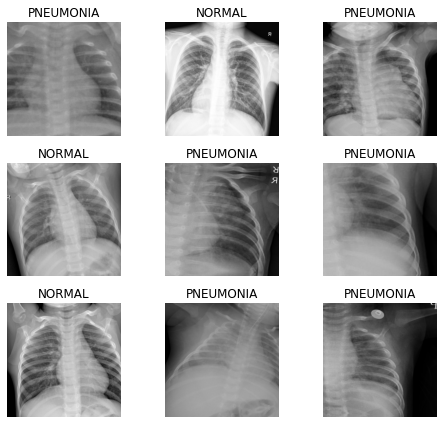

In [ ]:

np.random.seed(40)
data = ImageDataBunch.from_folder(train_img_file, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)

#7.Data partition 

In [ ]:
#train files
TRAIN_SAMPLES_N=len(os.listdir(os.path.join(train_img_file,'NORMAL')))
TRAIN_SAMPLES_P=len(os.listdir(os.path.join(train_img_file,'PNEUMONIA')))
TRAIN_SAMPLES=TRAIN_SAMPLES_P+TRAIN_SAMPLES_N

#test files
TEST_SAMPLES_N=len(os.listdir(os.path.join(test_img_file,'NORMAL')))
TEST_SAMPLES_P=len(os.listdir(os.path.join(test_img_file,'PNEUMONIA')))
TEST_SAMPLES=TEST_SAMPLES_P+TEST_SAMPLES_N

#Val files
VAL_SAMPLES_N=len(os.listdir(os.path.join(val_img_file,'NORMAL')))
VAL_SAMPLES_P=len(os.listdir(os.path.join(val_img_file,'PNEUMONIA')))
VAL_SAMPLES=VAL_SAMPLES_P+VAL_SAMPLES_N

# Total img sampales 
TOTAL_SAMPLES=VAL_SAMPLES+TRAIN_SAMPLES+TEST_SAMPLES

#Number of total Pneumonia , Normal imgs
COUNT_PNEUMONIA=TRAIN_SAMPLES_P+TEST_SAMPLES_P+VAL_SAMPLES_P
COUNT_NORMAL=TRAIN_SAMPLES_N+TEST_SAMPLES_N+VAL_SAMPLES_N

 

# 8.Data charts

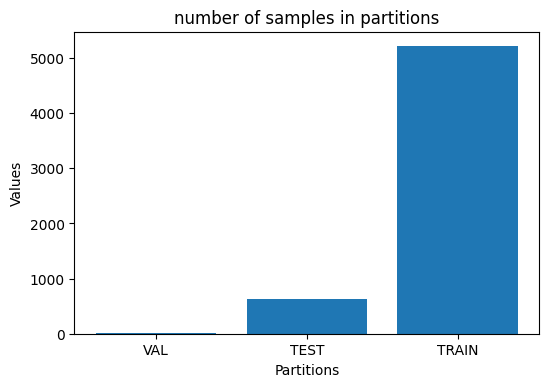

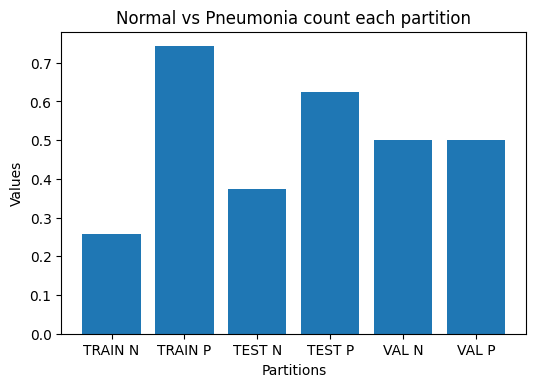

In [ ]:
#charts
def bar_partition():
  ## BAR plot
 
 value  = [VAL_SAMPLES, TEST_SAMPLES, TRAIN_SAMPLES]
 labels = ['VAL', 'TEST', 'TRAIN']

 plt.figure(figsize = (6, 4), dpi=100)
 plt.bar(labels, value)
 plt.title('number of samples in partitions')
 plt.xlabel('Partitions')
 plt.ylabel('Values')

bar_partition()

def bar2_partition():
  ## BAR plot

 value  = [(TRAIN_SAMPLES_N/TRAIN_SAMPLES),(TRAIN_SAMPLES_P/TRAIN_SAMPLES),(TEST_SAMPLES_N/TEST_SAMPLES),(TEST_SAMPLES_P/TEST_SAMPLES),(VAL_SAMPLES_N/VAL_SAMPLES), (VAL_SAMPLES_P/VAL_SAMPLES )]
 labels = ['TRAIN N','TRAIN P','TEST N','TEST P','VAL N','VAL P']

 plt.figure(figsize = (6, 4), dpi=100)
 plt.bar(labels, value)
 plt.title('Normal vs Pneumonia count each partition')
 plt.xlabel('Partitions')
 plt.ylabel('Values')

bar2_partition()


The ratio of images in our training dataset and in our validation set should be ~80:20. 
Also, the data is imbalanced with more images classified as pneumonia than normal. We will correct for that in this following section

#9.Fix data imbalance

In [ ]:
#samples to move from the train set to the validation set so train partition ~80%
train_part=TRAIN_SAMPLES/TOTAL_SAMPLES
pics_move=round((train_part-0.8)*TRAIN_SAMPLES)

#count the normal ,pneumonia samples needed to move 

pics_move_N=round((TRAIN_SAMPLES_N+VAL_SAMPLES_N)/(TRAIN_SAMPLES+VAL_SAMPLES)*pics_move)
pics_move_P=pics_move-pics_move_N



In [ ]:
#move n random images to VAL set from TRAIN set

def move_rand_files(from_dir,to_dir,n):
  for filename in sample(os.listdir(from_dir),k=n):
    from_path=os.path.join(from_dir,filename)
    to_path=os.path.join(to_dir,filename)
    shutil.move(from_path,to_path)
  display(f"move {n} files from {from_dir}to{to_dir}") 

#call move random files  method
move_rand_files(from_dir=os.path.join(train_img_file,'NORMAL'),
                to_dir=os.path.join(val_img_file,'NORMAL'),
                n=pics_move_N)

move_rand_files(from_dir=os.path.join(train_img_file,'PNEUMONIA'),
                to_dir=os.path.join(val_img_file,'PNEUMONIA'),
                n=pics_move_P)


'move 122 files from /content/chest_xray/train/NORMALto/content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIAto/content/chest_xray/val/PNEUMONIA'

#10.Data generation

In [ ]:

EPOCH=20
BATCH_SIZE=60
IMAGE_WIDTH,IMAGE_HIGHT=150,150

IMAGE_SIZE = [150, 150]

**10.1 image manipulation**

In [ ]:
#image manipulation 

train_data_gen = ImageDataGenerator(
                                rescale = 1./255,
                                shear_range = 0.22,
                                fill_mode='nearest',
                                zoom_range = 0.21,
                                height_shift_range=0.18,
                                width_shift_range=0.18,
                                horizontal_flip=True, 
                                vertical_flip=False,
                                rotation_range = 3,   

                               )

train_generator=train_data_gen.flow_from_directory(
    train_img_file,
    target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE,
    class_mode='binary',
)

train2_data_gen = ImageDataGenerator(
                                rescale = 1./255,
                                shear_range = 0.32,
                                fill_mode='nearest',
                                zoom_range = 0.13,
                                height_shift_range=0.28,
                                width_shift_range=0.28,
                                horizontal_flip=True, 
                                vertical_flip=True,
                                rotation_range = 8,   

                               )

train_data_gen= ImageDataGenerator(rescale=1./255)

test_data_gen= ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(
     test_img_file,
     shuffle=False, 
     target_size=(IMAGE_WIDTH,IMAGE_HIGHT),
     batch_size=BATCH_SIZE,
     class_mode='binary',
      )

val_generator = test_data_gen.flow_from_directory(
     val_img_file,
     shuffle=False, 
     target_size=(IMAGE_WIDTH,IMAGE_HIGHT),
     batch_size=BATCH_SIZE,
     class_mode='binary',
      )



Found 4743 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 489 images belonging to 2 classes.


#11.CNN Model

In [ ]:

inputs=Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model=Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))(inputs)


model=MaxPooling2D(pool_size=(2,2))(model)
model=Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu')(model)

model=MaxPooling2D(pool_size=(2,2))(model)
model=Conv2D(filters=64,kernel_size=(3,3),activation='relu')(model)

model=MaxPooling2D(pool_size=(2,2))(model)
model=Conv2D(filters=128,kernel_size=(3,3),activation='relu')(model)

model=MaxPooling2D(pool_size=(2,2))(model)
model=Conv2D(filters=256,kernel_size=(3,3),activation='relu')(model)
model=Conv2D(filters=256,kernel_size=(3,3),activation='relu')(model)
Dropout(0.5)

model=MaxPooling2D(pool_size=(2,2))(model)
model=tf.keras.layers.Flatten()(model)

model=Dense(activation='relu',units=128)(model)
Dropout(0.3)
model=Dense(activation='relu',units=64)(model)
Dropout(0.3)
outputs=Dense(activation='sigmoid',units=1)(model)

model=Model(inputs=inputs,outputs=outputs)

model.summary()


model.compile(optimizer='adam',
            loss='binary_crossentropy',
              metrics=['accuracy'])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928 

# 12.Train the model



In [ ]:
history=model.fit_generator(train_generator,
                         
                            epochs=EPOCH,
                            validation_data=val_generator,
                     
                            )

Epoch 1/20
85/85 [==============================] - 280s 3s/step - loss: 0.5936 - accuracy: 0.7375 - val_loss: 0.5809 - val_accuracy: 0.7330
Epoch 2/20
85/85 [==============================] - 278s 3s/step - loss: 0.5584 - accuracy: 0.7405 - val_loss: 0.5279 - val_accuracy: 0.7330
Epoch 3/20
85/85 [==============================] - 262s 3s/step - loss: 0.4184 - accuracy: 0.7923 - val_loss: 0.3561 - val_accuracy: 0.8557
Epoch 4/20
85/85 [==============================] - 258s 3s/step - loss: 0.3428 - accuracy: 0.8454 - val_loss: 0.2702 - val_accuracy: 0.8889
Epoch 5/20
85/85 [==============================] - 255s 3s/step - loss: 0.2969 - accuracy: 0.8776 - val_loss: 0.2491 - val_accuracy: 0.9038
Epoch 6/20
85/85 [==============================] - 263s 3s/step - loss: 0.2521 - accuracy: 0.8896 - val_loss: 0.1924 - val_accuracy: 0.9320
Epoch 7/20
29/85 [=========>....................] - ETA: 2:38 - loss: 0.2477 - accuracy: 0.8867

#13.Evaluate the model

In [ ]:
score=model.evaluate(test_generator)

11/11 [==============================] - 10s 819ms/step - loss: 0.3910 - accuracy: 0.8766


#14.Results charts


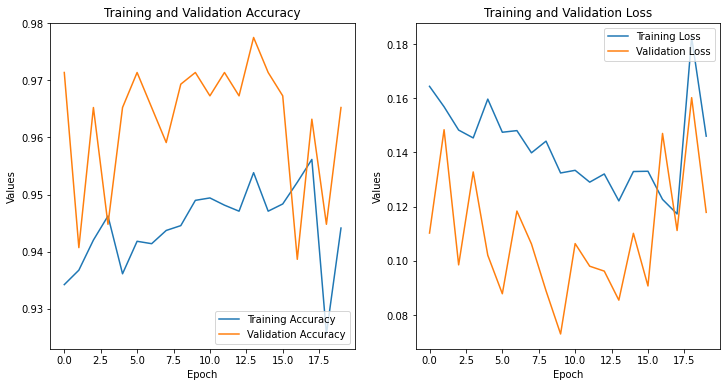

In [ ]:
#plot charts

Accuracy = history.history['accuracy']
val_Acc = history.history['val_accuracy']

Loss = history.history['loss']
val_Loss = history.history['val_loss']

#epochs=20
Epochs_Range = range(20)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Epochs_Range, Accuracy, label='Training Accuracy')
plt.plot(Epochs_Range, val_Acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(Epochs_Range, Loss, label='Training Loss')
plt.plot(Epochs_Range, val_Loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#15.confusion metrix

In [ ]:
#cmap = confusion_matrix(, )
#plt.figure(figsize = (4, 4), dpi = 150)
#hm = sns.heatmap(data=cmap,
               #  annot=True,
                # fmt='g')

SyntaxError: ignored

# 16.Predective model

In [ ]:
#predective
def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    model = tf.keras.applications.resnet50.ResNet50()
    prediction = model.predict(img_preprocessed)

    print(decode_predictions(prediction, top=3)[0])

In [ ]:
#classify sample image

# define image path
img_path='/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
classify(img_path)

**16.1 test predective model **

# 17.Resources

# 18.Members
Shather Alrifai ,Reem Alghamdi,Joud Alsuhaibani